# Shallow Water Equations

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import numpy as np
import numba as nb
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import typing as tp
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from jaxsw._src.domain.base import Domain
from jaxsw._src.models.pde import DynamicalSystem
from jaxsw._src.domain.time import TimeDomain

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Formulation

$$
\begin{aligned}
\frac{\partial h}{\partial t} &+ H
\left(\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} \right) = 0 \\
\frac{\partial u}{\partial t} &- fv =
- g \frac{\partial h}{\partial x}
- \kappa u \\
\frac{\partial v}{\partial t} &+ fu =
- g \frac{\partial h}{\partial y}
- \kappa v
\end{aligned}
$$ (eq:sw_linear)

## Domain



In [2]:
dx = dy = 20e3
Lx = 100 * dx
Ly = 101 * dy


domain = Domain(xmin=(0, 0), xmax=(Lx, Ly), dx=(dx, dy))

print(f"Nx: {domain.Nx}")
print(f"Lx: {domain.Lx}")
print(f"dx: {domain.dx}")
print(f"Size: {domain.size}")
print(f"nDims: {domain.ndim}")
print(f"Grid Size: {domain.grid.shape}")
print(f"Cell Volume: {domain.cell_volume}")

Nx: (101, 102)
Lx: (2000000.0, 2020000.0)
dx: (20000.0, 20000.0)
Size: (101, 102)
nDims: 2
Grid Size: (101, 102, 2)
Cell Volume: 400000000.0


## Initial Condition

```python

# grid setup
x, y = (
    np.arange(n_x) * dx,
    np.arange(n_y) * dy
)
Y, X = np.meshgrid(y, x, indexing='ij')
# initial conditions
h0 = depth + 1.0 * np.exp(
    - (X - x[n_x // 2]) ** 2 / rossby_radius ** 2
    - (Y - y[n_y - 2]) ** 2 / rossby_radius ** 2
)
u0 = np.zeros_like(h0)
v0 = np.zeros_like(h0)
```

In [5]:
from jaxtyping import Array


class State(tp.NamedTuple):
    u: Array
    v: Array
    h: Array

    @classmethod
    def init_state(cls, params, init_h):
        h = init_h0(params)
        v = jnp.zeros_like(h)
        u = jnp.zeros_like(h)
        return cls(u=u, v=v, h=h)


class Params(tp.NamedTuple):
    depth: float
    gravity: float
    coriolis: float  # of ARRAY
    domain: Domain

    @property
    def rossby_radius(self):
        return np.sqrt(self.gravity * self.depth) / self.coriolis


def init_h0(params):
    """A LOT of work for a lil Gauss bump!"""
    domain = params.domain

    X = domain.grid[..., 0]
    Y = domain.grid[..., 1]

    x_center = domain.coords[0][domain.Nx[0] // 2]
    y_center = domain.coords[1][domain.Nx[1] - 2]

    h0 = params.depth + 1.0 * np.exp(
        -((X - x_center) ** 2) / params.rossby_radius**2
        - (Y - y_center) ** 2 / params.rossby_radius**2
    )

    return jnp.asarray(h0)


params = Params(depth=100.0, gravity=9.81, coriolis=2e-4, domain=domain)

state_init = State.init_state(params, init_h0)

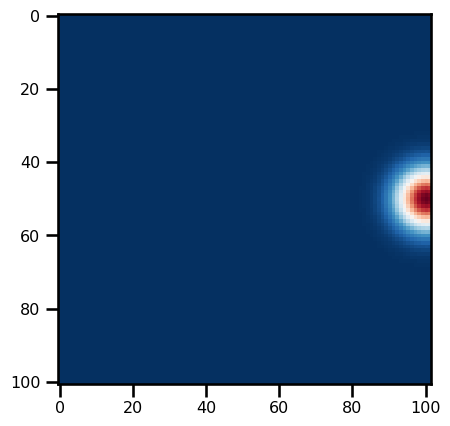

In [8]:
plt.imshow(state_init.h, cmap="RdBu_r")

In [10]:
depth = 100.0
gravity = 9.81
coriolis = 2e-4
rossby_radius = np.sqrt(gravity * depth) / coriolis
X = domain.grid[..., 0]
Y = domain.grid[..., 1]

x_center = domain.coords[0][domain.Nx[0] // 2]
y_center = domain.coords[1][domain.Nx[1] - 2]

h0 = depth + 1.0 * np.exp(
    -((X - x_center) ** 2) / rossby_radius**2
    - (Y - y_center) ** 2 / rossby_radius**2
)

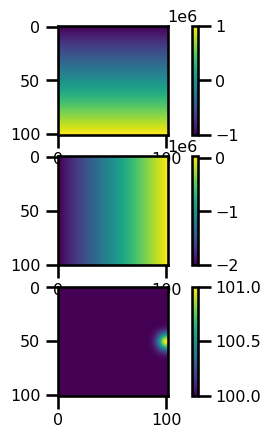

In [11]:
fig, ax = plt.subplots(nrows=3)

pts = ax[0].imshow(X - x_center)
plt.colorbar(pts)
pts = ax[1].imshow(Y - y_center)
plt.colorbar(pts)
pts = ax[2].imshow(h0)
plt.colorbar(pts)

In [12]:
domain.coords[0][domain.Nx[0] // 2]

Array(1000000., dtype=float64)

In [13]:
X.shape, domain.coords[0][domain.Nx[0] // 2].shape

((101, 102), ())

## Boundary Conditions

## Equation of Motion

### V Component


```python
# update v
u_avg = 0.25 * (u[1:-1, 1:-1] + u[1:-1, :-2] + u[2:, 1:-1] + u[2:, :-2])
v[1:-1, 1:-1] = v[1:-1, 1:-1] + dt * (
    - coriolis_param * u_avg
    - gravity * (h[2:, 1:-1] - h[1:-1, 1:-1]) / dy
)
v[-2, :] = 0
```


```python
Equation:
    ∂h/∂t + H (∂u/∂x + ∂v/∂y) = 0
    ∂u/∂t - fv = - g ∂h/∂x - ku
    ∂v/∂t + fu = - g ∂h/∂y - kv
```

In [56]:
from jaxsw._src.operators.functional import grid as F_grid

v_rhs = jnp.zeros_like(state_init.v)

u_avg = jnp.pad(
    state_init.u, pad_width=((0, 1), (0, 1)), mode="constant", constant_values=0.0
)
u_avg = F_grid.center_average_2D(u_avg, padding="valid")
u_avg *= -params.coriolis

dh_dy = fdx.difference(
    state_init.h, axis=1, accuracy=1, method="central", step_size=domain.dx[1]
)
dh_dy *= -params.gravity

v_rhs = v_rhs.at[1:-1, 1:-1].set(u_avg[1:-1, 1:-1] + dh_dy[1:-1, 1:-1])


state_init.u.shape, u_avg.shape, dh_dy.shape

((101, 102), (101, 102), (101, 102))

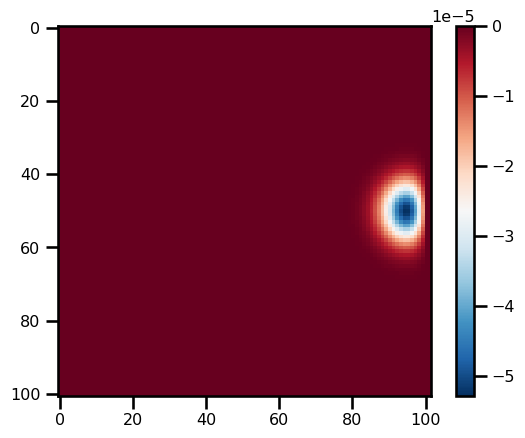

In [57]:
pts = plt.imshow(v_rhs, cmap="RdBu_r")
plt.colorbar(pts)

### U Component

```python
# update u
v_avg = 0.25 * (v[1:-1, 1:-1] + v[:-2, 1:-1] + v[1:-1, 2:] + v[:-2, 2:])
u[1:-1, 1:-1] = u[1:-1, 1:-1] + dt * (
    + coriolis_param * v_avg
    - gravity * (h[1:-1, 2:] - h[1:-1, 1:-1]) / dx
)
u[:, -2] = 0
```


```python
Equation:
    ∂h/∂t + H (∂u/∂x + ∂v/∂y) = 0
    ∂u/∂t - fv = - g ∂h/∂x - ku
    ∂v/∂t + fu = - g ∂h/∂y - kv
```

In [58]:
u_rhs = jnp.zeros_like(state_init.u)

v_avg = jnp.pad(
    state_init.v, pad_width=((0, 1), (0, 1)), mode="constant", constant_values=0.0
)
print(u_rhs.shape, v_avg.shape)
v_avg = F_grid.center_average_2D(v_avg, padding="valid")
v_avg *= +params.coriolis
print(u_rhs.shape, v_avg.shape)

dh_dx = fdx.difference(
    state_init.h, axis=0, accuracy=1, method="central", step_size=domain.dx[0]
)
dh_dx *= -params.gravity

u_rhs = u_rhs.at[1:-1, 1:-1].set(v_avg[1:-1, 1:-1] + dh_dx[1:-1, 1:-1])


state_init.v.shape, v_avg.shape, dh_dx.shape

(101, 102) (102, 103)
(101, 102) (101, 102)


((101, 102), (101, 102), (101, 102))

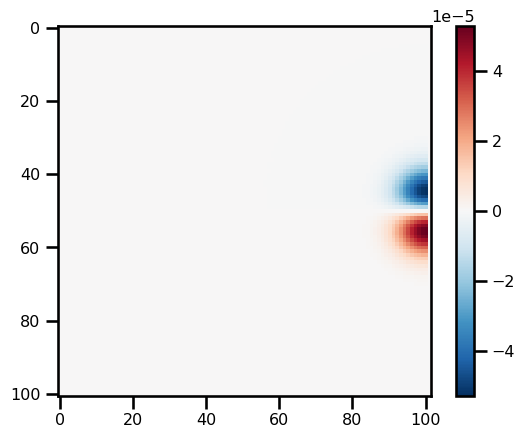

In [59]:
pts = plt.imshow(u_rhs, cmap="RdBu_r")
plt.colorbar(pts)

### H Component

```python
# update h
h[1:-1, 1:-1] = h[1:-1, 1:-1] - dt * depth * (
    (u[1:-1, 1:-1] - u[1:-1, :-2]) / dx
    + (v[1:-1, 1:-1] - v[:-2, 1:-1]) / dy
)
```

In [61]:
h_rhs = jnp.zeros_like(state_init.h)

du_dx = fdx.difference(
    state_init.u, axis=0, accuracy=1, method="central", step_size=domain.dx[0]
)
dv_dy = fdx.difference(
    state_init.v, axis=1, accuracy=1, method="central", step_size=domain.dx[1]
)

h_rhs = h_rhs.at[1:-1, 1:-1].set(
    -params.depth * (du_dx[1:-1, 1:-1] + dv_dy[1:-1, 1:-1])
)

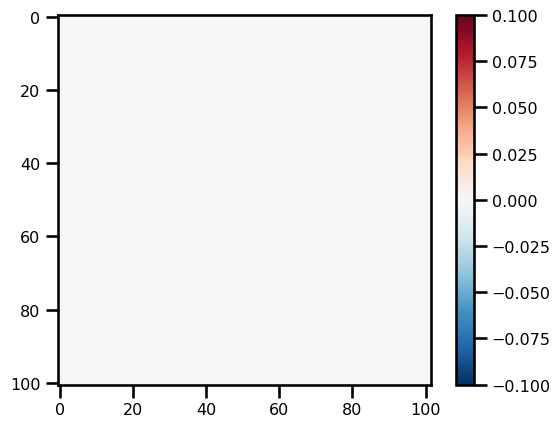

In [62]:
pts = plt.imshow(h_rhs, cmap="RdBu_r")
plt.colorbar(pts)

In [96]:
class LinearShallowWater2D(DynamicalSystem):
    @staticmethod
    def equation_of_motion(t: float, state: State, args):
        """2D Linear Shallow Water Equations

        Equation:
            ∂h/∂t + H (∂u/∂x + ∂v/∂y) = 0
            ∂u/∂t - fv = - g ∂h/∂x - ku
            ∂v/∂t + fu = - g ∂h/∂y - kv
        """
        # unpack state
        u, v, h = state.u, state.v, state.h

        # unpack params
        depth, coriolis, gravity, domain = (
            args.depth,
            args.coriolis,
            args.gravity,
            args.domain,
        )

        # # Apply Boundary Conditions
        # u = bc_fn(u)
        # v = bc_fn(v)
        u = u.at[:, -2].set(jnp.asarray(0.0))
        v = v.at[-2, :].set(jnp.asarray(0.0))

        ################
        # V COMPONENT
        # ∂v/∂t = - fu - g ∂h/∂y
        ###############

        v_rhs = jnp.zeros_like(v)

        u_avg = jnp.pad(
            u, pad_width=((0, 1), (0, 1)), mode="constant", constant_values=0.0
        )
        u_avg = F_grid.center_average_2D(u_avg, padding="valid")
        u_avg *= -coriolis

        dh_dy = fdx.difference(
            h, axis=1, accuracy=1, method="central", step_size=domain.dx[1]
        )
        dh_dy *= -gravity

        # v_rhs = v_rhs.at[1:-1,1:-1].set(u_avg[1:-1,1:-1] + dh_dy[1:-1,1:-1])
        v_rhs = u_avg + dh_dy

        ################
        # U COMPONENT
        # ∂u/∂t = fv - g ∂h/∂x
        ################

        u_rhs = jnp.zeros_like(u)

        v_avg = jnp.pad(
            v, pad_width=((0, 1), (0, 1)), mode="constant", constant_values=0.0
        )
        v_avg = F_grid.center_average_2D(v_avg, padding="valid")
        v_avg *= coriolis

        dh_dx = fdx.difference(
            h, axis=0, accuracy=1, method="central", step_size=domain.dx[0]
        )
        dh_dx *= -gravity

        # u_rhs = u_rhs.at[1:-1,1:-1].set(v_avg[1:-1,1:-1] + dh_dx[1:-1,1:-1])
        u_rhs = v_avg + dh_dx

        ################
        # H COMPONENT
        # ∂h/∂t = - H (∂u/∂x + ∂v/∂y)
        ################
        h_rhs = jnp.zeros_like(h)

        du_dx = fdx.difference(
            u, axis=0, accuracy=1, method="central", step_size=domain.dx[0]
        )
        dv_dy = fdx.difference(
            v, axis=1, accuracy=1, method="central", step_size=domain.dx[1]
        )

        h_rhs = u_rhs.at[1:-1, 1:-1].set(
            -depth * (du_dx[1:-1, 1:-1] + dv_dy[1:-1, 1:-1])
        )
        # h_rhs = - depth * (du_dx + dv_dy)

        # update state
        state = eqx.tree_at(lambda x: x.u, state, u_rhs)
        state = eqx.tree_at(lambda x: x.v, state, v_rhs)
        state = eqx.tree_at(lambda x: x.h, state, h_rhs)
        return state

In [97]:
state_update = LinearShallowWater2D.equation_of_motion(0, state_init, params)

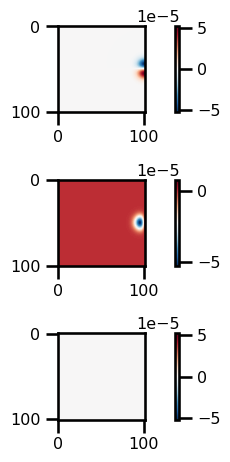

In [98]:
fig, ax = plt.subplots(nrows=3)
pts = ax[0].imshow(state_update.u, cmap="RdBu_r")
plt.colorbar(pts)
pts = ax[1].imshow(state_update.v, cmap="RdBu_r")
plt.colorbar(pts)
pts = ax[2].imshow(state_update.h, cmap="RdBu_r")
plt.colorbar(pts)
plt.tight_layout()

## Time Stepping

In [109]:
# TEMPORAL DISCRETIZATION
# initialize temporal domain

dt = 0.25 * domain.dx[0] / np.sqrt(params.gravity * params.depth)
print(f"Step Size (dt): {dt:.4e}")

tmin = 0.0
tmax = 6e3  # (np.arange(120) * dt).max()
num_save = 20

Step Size (dt): 1.5964e+02


In [110]:
t_domain = TimeDomain(tmin=tmin, tmax=tmax, dt=dt)
ts = jnp.linspace(tmin, tmax, num_save)
saveat = dfx.SaveAt(ts=ts)

# DYNAMICAL SYSTEM
dyn_model = LinearShallowWater2D(t_domain=t_domain, saveat=saveat)

### Integration

In [111]:
# Euler, Constant StepSize
solver = dfx.Euler()
stepsize_controller = dfx.ConstantStepSize()

# SPATIAL DISCRETIZATION
params_init = Params(depth=100.0, gravity=9.81, coriolis=2e-4, domain=domain)
state_init = State.init_state(params_init, init_h0)


# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(dyn_model.equation_of_motion),
    solver=solver,
    t0=ts.min(),
    t1=ts.max(),
    dt0=dt,
    y0=state_init,
    saveat=saveat,
    args=params_init,
    stepsize_controller=stepsize_controller,
)

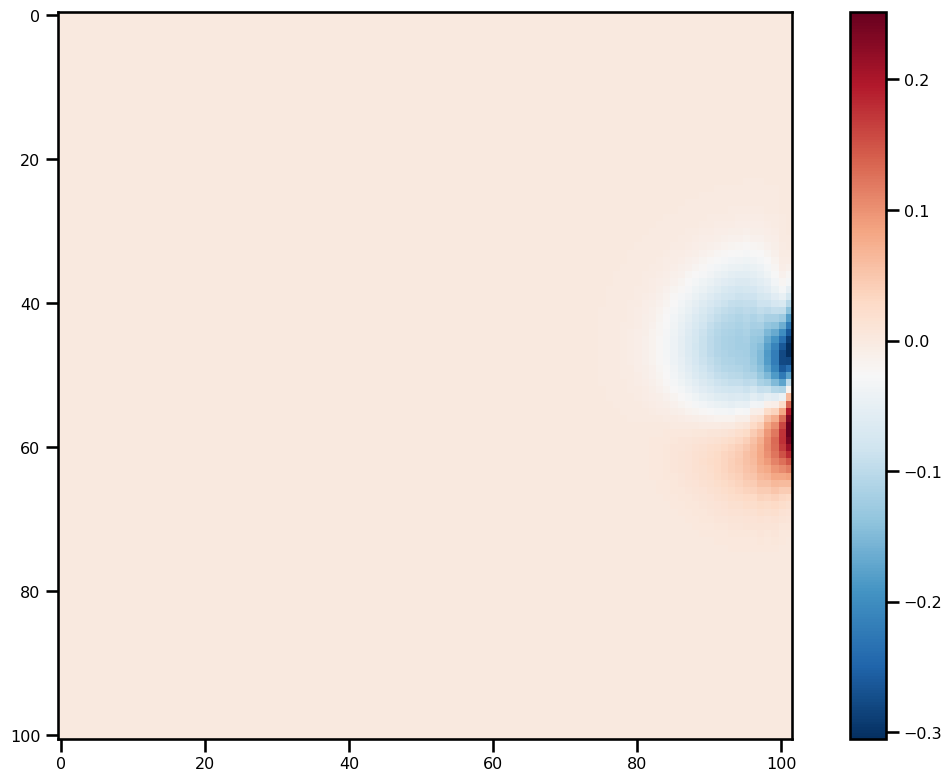

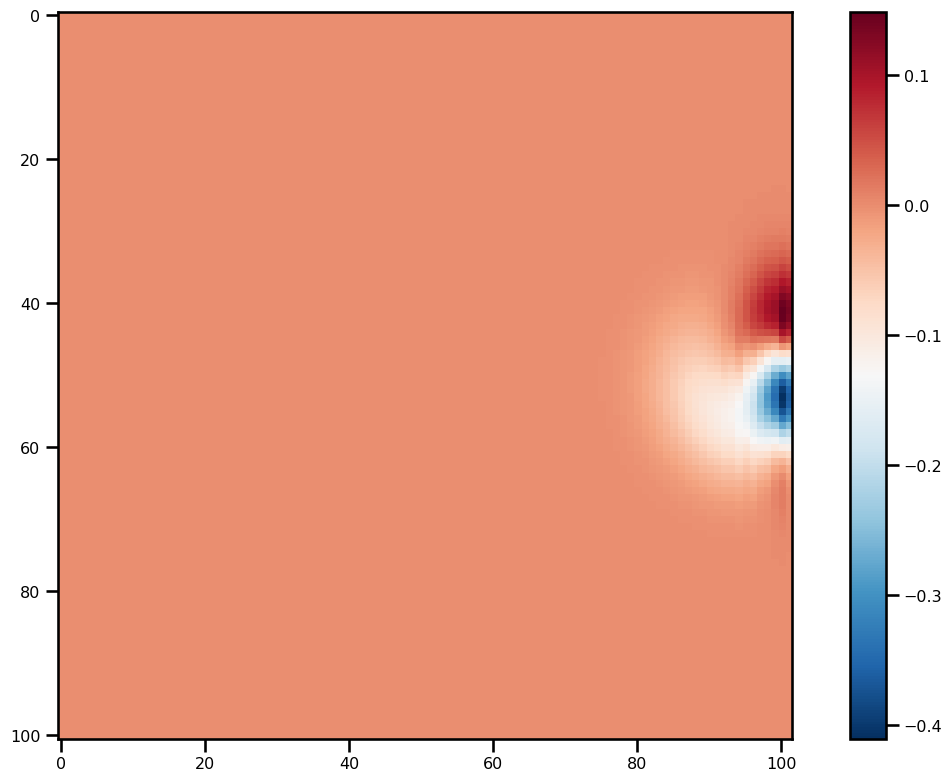

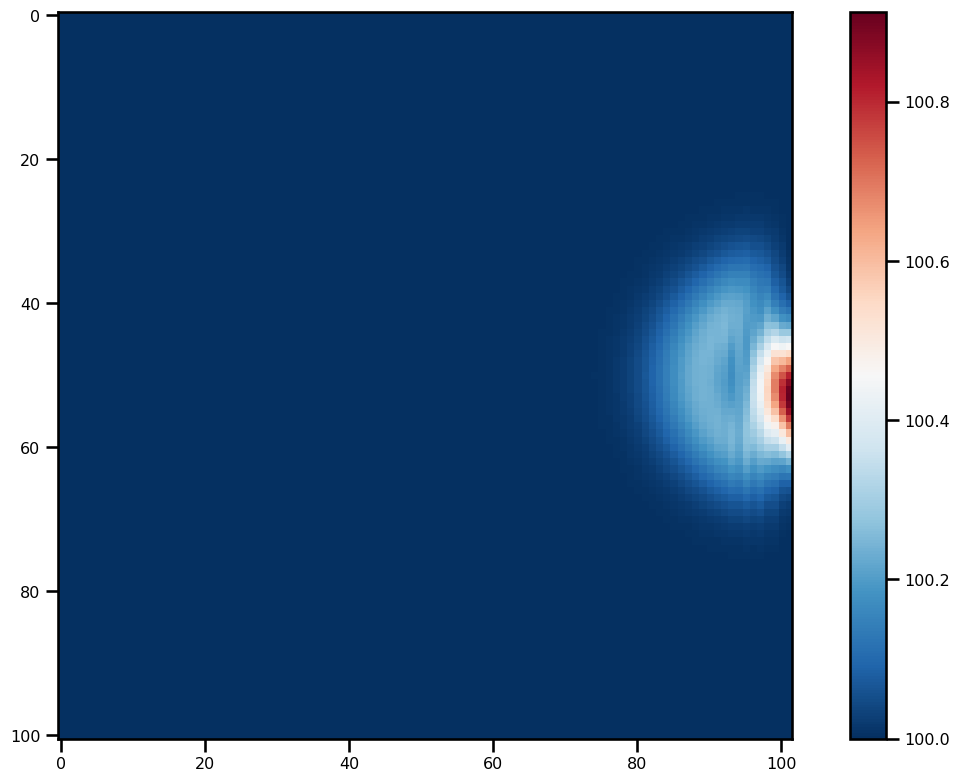

In [112]:
for ivar in sol.ys:
    fig, ax = plt.subplots(figsize=(12, 8))
    pts = ax.imshow(ivar[-1], cmap="RdBu_r")
    plt.colorbar(pts)
    plt.tight_layout()

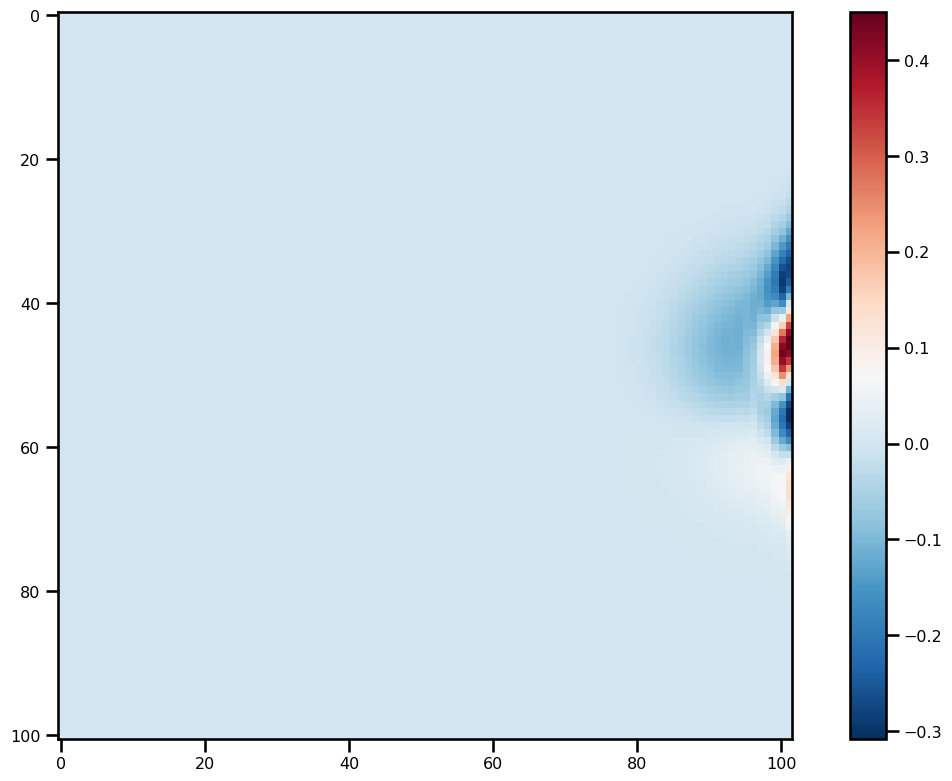

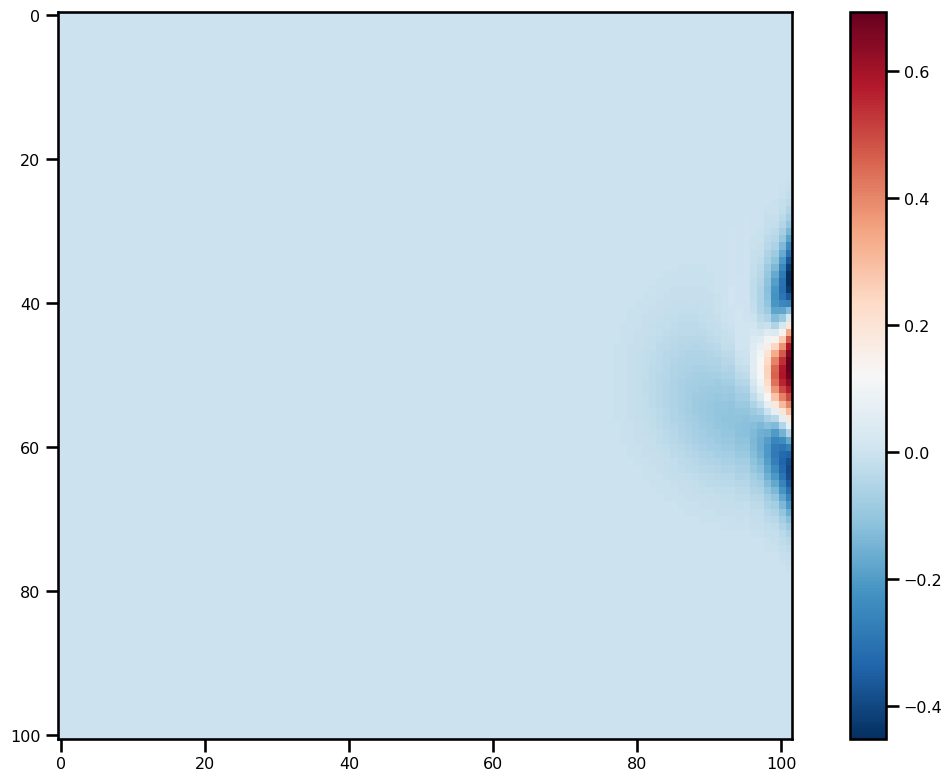

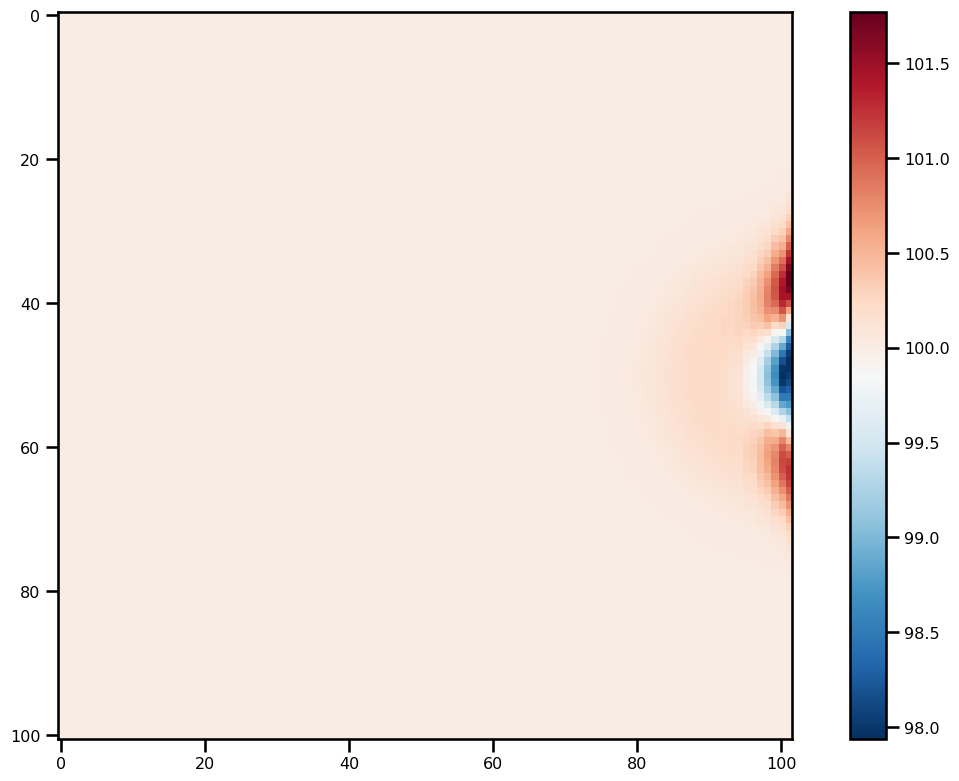

In [95]:
for ivar in sol.ys:
    fig, ax = plt.subplots(figsize=(12, 8))
    pts = ax.imshow(ivar[-1], cmap="RdBu_r")
    plt.colorbar(pts)
    plt.tight_layout()

## Analysis

In [58]:
da_sol = xr.Dataset(
    data_vars={
        "u": (("time", "x", "y"), np.asarray(sol.ys[0])),
        "v": (("time", "x", "y"), np.asarray(sol.ys[1])),
    },
    coords={
        "x": (["x"], np.asarray(domain.coords[0])),
        "y": (["y"], np.asarray(domain.coords[1])),
        "time": (["time"], np.asarray(sol.ts)),
    },
    attrs={"pde": "nonlinear_convection", "sigma": sigma},
)
da_sol

<xarray.Dataset>
Dimensions:  (time: 20, x: 41, y: 41)
Coordinates:
  * x        (x) float64 0.0 0.05 0.1 0.15 0.2 0.25 ... 1.8 1.85 1.9 1.95 2.0
  * y        (y) float64 0.0 0.05 0.1 0.15 0.2 0.25 ... 1.8 1.85 1.9 1.95 2.0
  * time     (time) float64 0.0 0.02632 0.05263 0.07895 ... 0.4474 0.4737 0.5
Data variables:
    u        (time, x, y) float64 1.0 1.0 1.0 1.0 1.0 ... 1.001 1.0 1.0 1.0
    v        (time, x, y) float64 1.0 1.0 1.0 1.0 1.0 ... 1.001 1.0 1.0 1.0
Attributes:
    pde:      nonlinear_convection
    sigma:    0.0009